In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import folium as folium
from os import path
from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from matplotlib_venn import venn3, venn3_circles
%matplotlib inline

# TP1

In [2]:
df_original = pd.read_csv("train.csv", dtype={
    'tipodepropiedad':'category', 'ciudad':'category',\
    'provincia':'category', 'gimnasio':'bool', 'usosmultiples':'bool',\
    'piscina':'bool', 'escuelascercanas':'bool',\
    'centroscomercialescercanos':'bool' }, parse_dates=[16])

In [3]:
# Renombramos convenientemente algunas columnas
df_original = df_original.rename(columns={'tipodepropiedad':'tipo', 'habitaciones':'cant_habitaciones', 'garages':'cant_garages', 'banos':'cant_banios',
       'lat':'latitud', 'lng':'longitud'})

In [4]:
df_original.columns

Index(['id', 'titulo', 'descripcion', 'tipo', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'cant_habitaciones', 'cant_garages',
       'cant_banios', 'metroscubiertos', 'metrostotales', 'idzona', 'latitud',
       'longitud', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio'],
      dtype='object')

In [123]:
# Identificamos para cada columna qué porcentaje de los datos de cada columna son nulos 

porcentajes = df_original.isna().sum()/len(df_original.index)

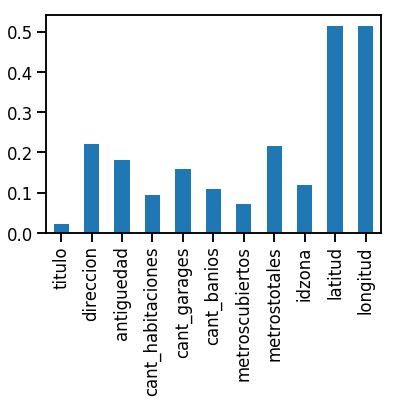

In [124]:
porcentajes_mayores_1 = porcentajes[porcentajes >= 0.01]
porcentajes_mayores_1.plot(kind='bar')

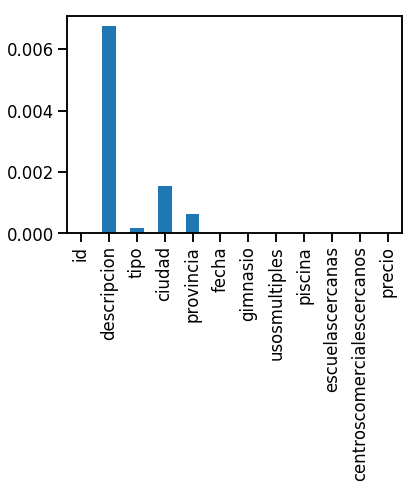

In [125]:
porcentajes_menores_1 = porcentajes[porcentajes < 0.01]
porcentajes_menores_1.plot(kind='bar')

In [126]:
df_original['anio'] = df_original['fecha'].dt.year

In [127]:
df_original['mes'] = df_original['fecha'].dt.month

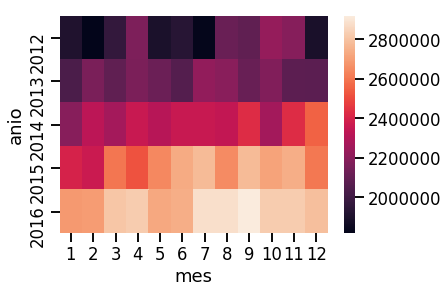

In [128]:
mes_x_anio = df_original.pivot_table(index='anio', columns='mes', values='precio', aggfunc='mean')
g = sns.heatmap(mes_x_anio)

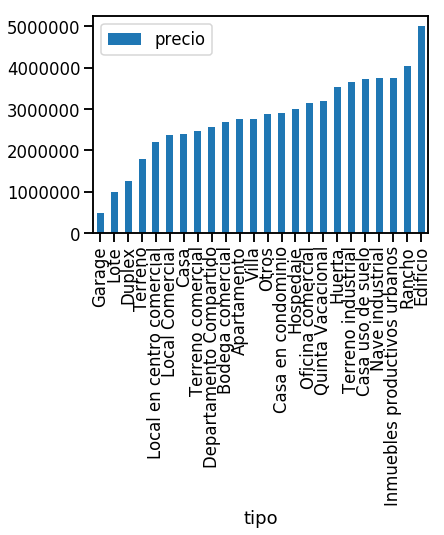

In [129]:
# Precio promedio por tipo
df_original.groupby('tipo').agg({'precio':'mean'}).sort_values('precio').plot(kind='bar')

Text(0.5, 1.0, 'Cantidad total de propiedades')

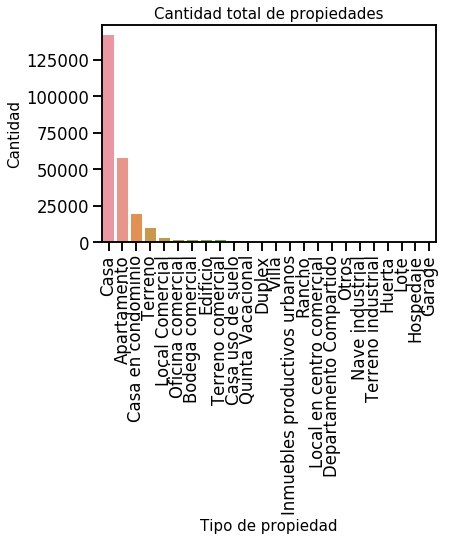

In [130]:
g = sns.countplot(x='tipo', data=df_original, order=df_original['tipo'].value_counts().index, orient='v')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Tipo de propiedad", fontsize=15)
g.set_ylabel("Cantidad", fontsize=15)
g.set_title("Cantidad total de propiedades", fontsize=15)

# Filtracion

In [5]:
## funcion para setear los superficies
def set_metros(row):
    total = row.metrostotales
    covered = row.metroscubiertos
    if np.isnan(total):
        row.metrostotales = covered
        return row
    if np.isnan(covered):
        row.metroscubiertos = total
        return row
    return row

In [6]:
df_filtrado_metro = df_original.copy()
df_filtrado_metro[['metrostotales', 'metroscubiertos']] = df_filtrado_metro[['metrostotales', 'metroscubiertos']].apply(set_metros, axis = 1)

In [7]:
# chequeo las infos antes de filtrar
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipo                          239954 non-null category
direccion                     186928 non-null object
ciudad                        239628 non-null category
provincia                     239845 non-null category
antiguedad                    196445 non-null float64
cant_habitaciones             217529 non-null float64
cant_garages                  202235 non-null float64
cant_banios                   213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
latitud                       116512 non-null float64
longitud                      116512 non-null float64
fecha                      

In [134]:
## informacion despues de filtrar
df_filtrado_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 25 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipo                          239954 non-null category
direccion                     186928 non-null object
ciudad                        239628 non-null category
provincia                     239845 non-null category
antiguedad                    196445 non-null float64
cant_habitaciones             217529 non-null float64
cant_garages                  202235 non-null float64
cant_banios                   213779 non-null float64
metroscubiertos               240000 non-null float64
metrostotales                 240000 non-null float64
idzona                        211379 non-null float64
latitud                       116512 non-null float64
longitud                      116512 non-null float64
fecha                      

In [135]:
# verificando los percentajes de cada tipo
df_filtrado_metro['tipo'].value_counts(normalize = 1)

Casa                             0.590601
Apartamento                      0.238967
Casa en condominio               0.080420
Terreno                          0.041445
Local Comercial                  0.012732
Oficina comercial                0.007256
Bodega comercial                 0.005859
Edificio                         0.005818
Terreno comercial                0.005526
Casa uso de suelo                0.002951
Quinta Vacacional                0.001646
Duplex                           0.001429
Villa                            0.001417
Inmuebles productivos urbanos    0.000833
Rancho                           0.000708
Local en centro comercial        0.000688
Departamento Compartido          0.000588
Otros                            0.000558
Nave industrial                  0.000317
Terreno industrial               0.000129
Huerta                           0.000083
Lote                             0.000021
Hospedaje                        0.000004
Garage                           0

Se puede observar que a partir de Local Comercial, tiene un percentaje menor que 2%, por lo tanto decidimos que agrupar las propiedades que tienen un porcentaje menor que 2% a tipo 'otro'

In [11]:
# funcion para setear los tipos
def set_tipo(tipo):
    tipos_a_conservar = set(['Casa', 'Apartamento', 'Terreno', 'Casa en condominio'])
    if tipo in tipos_a_conservar:
        return tipo
    return 'Otros'


In [12]:
df_filtrado_tipo = df_filtrado_metro.copy()
df_filtrado_tipo['tipo'] = df_filtrado_tipo['tipo'].apply(set_tipo)
df_filtrado_tipo['tipo'].unique()

array(['Apartamento', 'Casa en condominio', 'Casa', 'Terreno', 'Otros'], dtype=object)

In [13]:
# verificando los datos despues de filtrar y percentajes de los tipos
df_filtrado_tipo.info()
df_filtrado_tipo['tipo'].value_counts(normalize = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipo                          240000 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null category
provincia                     239845 non-null category
antiguedad                    196445 non-null float64
cant_habitaciones             217529 non-null float64
cant_garages                  202235 non-null float64
cant_banios                   213779 non-null float64
metroscubiertos               240000 non-null float64
metrostotales                 240000 non-null float64
idzona                        211379 non-null float64
latitud                       116512 non-null float64
longitud                      116512 non-null float64
fecha                        

Casa                  0.590488
Apartamento           0.238921
Casa en condominio    0.080404
Otros                 0.048750
Terreno               0.041438
Name: tipo, dtype: float64

agregando una columna de precio por metros en dollar y genera una nueva data_set con solo'tipo','metrostotales','precio por metros'

In [14]:
df_filtrado_tipo['precio por metros'] = df_filtrado_tipo.precio/df_filtrado_tipo.metrostotales/50
df_filtrado = df_filtrado_tipo.copy()
df_tipo_precio = df_filtrado_tipo[['tipo','precio por metros']]
df_tipo_precio.info()

df_filtrado['precioporm2'] = df_filtrado['precio'] / df_filtrado['metrostotales']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 2 columns):
tipo                 240000 non-null object
precio por metros    240000 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


## los datos filtrados ahora se llama df_filtrado

# Analizando los tipos de propiedades

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3873d66eb8>],
      dtype=object)

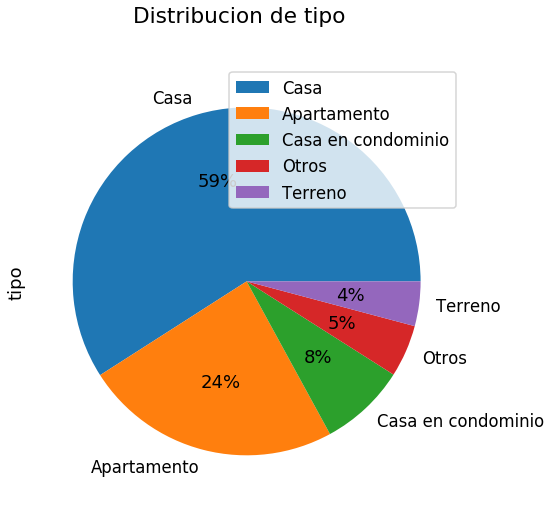

In [140]:
# un grafico de presentar percentajes de cada tipo
df_tipo = df_tipo_precio['tipo'].value_counts().to_frame()
df_tipo.plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.0f%%',title='Distribucion de tipo')

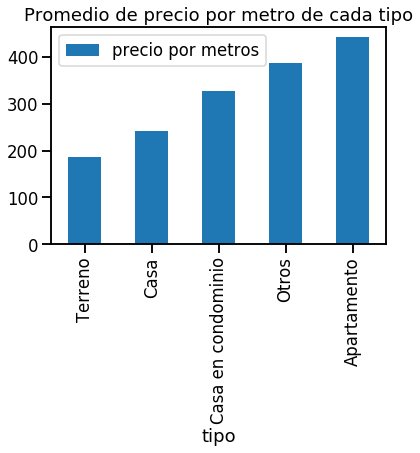

In [141]:
#analiza promedio de precio por medio de cada tipo
df_tipo_precio.groupby('tipo').agg({'precio por metros':'mean'}).sort_values('precio por metros').plot(kind='bar', title = 'Promedio de precio por metro de cada tipo')

Analizando promedio de precio por metro en cada provincia segun el tipo

In [142]:
#filtrando uno con precio tipo y provincia (falta elegir un mejor grafico)
df_tipo_provincia = df_filtrado [['provincia','precio por metros','tipo']]
df_tp = df_tipo_provincia.groupby(['tipo','provincia']).agg({'precio por metros' :'mean'})
df_tp = df_tp.reset_index()

[Text(0, 0, 'Aguascalientes'),
 Text(0, 0, 'Baja California Norte'),
 Text(0, 0, 'Baja California Sur'),
 Text(0, 0, 'Campeche'),
 Text(0, 0, 'Chiapas'),
 Text(0, 0, 'Chihuahua'),
 Text(0, 0, 'Coahuila'),
 Text(0, 0, 'Colima'),
 Text(0, 0, 'Distrito Federal'),
 Text(0, 0, 'Durango'),
 Text(0, 0, 'Edo. de México'),
 Text(0, 0, 'Guanajuato'),
 Text(0, 0, 'Guerrero'),
 Text(0, 0, 'Hidalgo'),
 Text(0, 0, 'Jalisco'),
 Text(0, 0, 'Michoacán'),
 Text(0, 0, 'Morelos'),
 Text(0, 0, 'Nayarit'),
 Text(0, 0, 'Nuevo León'),
 Text(0, 0, 'Oaxaca'),
 Text(0, 0, 'Puebla'),
 Text(0, 0, 'Querétaro'),
 Text(0, 0, 'Quintana Roo'),
 Text(0, 0, 'San luis Potosí'),
 Text(0, 0, 'Sinaloa'),
 Text(0, 0, 'Sonora'),
 Text(0, 0, 'Tabasco'),
 Text(0, 0, 'Tamaulipas'),
 Text(0, 0, 'Tlaxcala'),
 Text(0, 0, 'Veracruz'),
 Text(0, 0, 'Yucatán'),
 Text(0, 0, 'Zacatecas')]

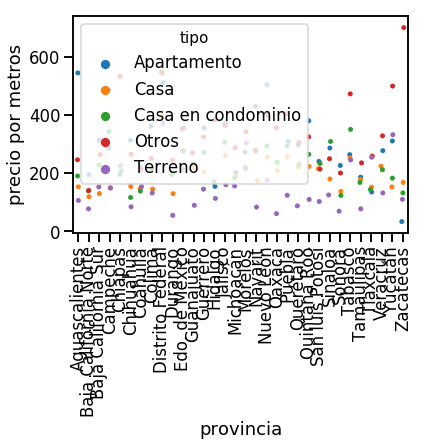

In [143]:
g= sns.stripplot(x='provincia', y='precio por metros', hue= 'tipo', data=df_tp, order=None, 
                      hue_order=None, jitter=True, 
                      split=False, orient=None, 
                      color=None, palette=None, size=5, 
                      edgecolor="gray", linewidth=0, 
                      ax=None)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

# Analizando los factores de escuelas y centroscomerciales

In [144]:
#filtrando dato solo con tipo precio y escuelas cercanas
df_escuela = df_filtrado [['tipo','precio por metros', 'escuelascercanas']]
df_escuela.head()

,tipo,precio por metros,escuelascercanas
0,Apartamento,568.250000,False
1,Casa en condominio,400.000000,True
2,Casa,144.578313,False
3,Casa,194.029851,True
4,Apartamento,242.105263,False


[Text(0, 0, 'False'), Text(0, 0, 'True')]

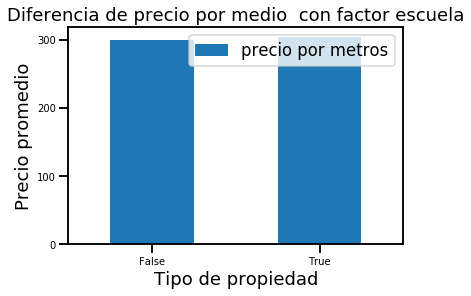

In [145]:
# comparando precio pormedio directamente con el factor de escuela
df_ec_precio = df_escuela.groupby('escuelascercanas').agg({'precio por metros' :'mean'})
g = df_ec_precio.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor escuela", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=0)

In [146]:
# filtrar el factor escuelas con diferentes tipos
df_ec_tipo = df_escuela.groupby(['tipo','escuelascercanas']).agg({'precio por metros' :'mean'})
df_ec = df_ec_tipo.pivot_table(index="tipo", \
                                 columns="escuelascercanas", \
                                 values="precio por metros", fill_value=0)
df_ec = df_ec.reset_index()
df_ec.set_index('tipo', inplace=True) 
df_ec

escuelascercanas,False,True
tipo,,
Apartamento,445.430887,438.436273
Casa,239.410114,246.292103
Casa en condominio,327.774681,326.766741
Otros,374.969889,430.745624
Terreno,177.799402,201.825125


Text(0, 0.5, 'Precio promedio')

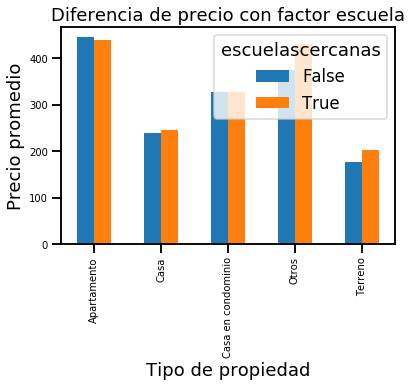

In [147]:
# representa en grafico
g = df_ec.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio con factor escuela", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)

In [148]:
# filtrar dato con 3 columnas tipo, precio por medio y centroscomerciales
df_centrocomercial = df_filtrado [['tipo','precio por metros', 'centroscomercialescercanos']]
df_centrocomercial.head()

,tipo,precio por metros,centroscomercialescercanos
0,Apartamento,568.250000,False
1,Casa en condominio,400.000000,True
2,Casa,144.578313,False
3,Casa,194.029851,True
4,Apartamento,242.105263,False


[Text(0, 0, 'False'), Text(0, 0, 'True')]

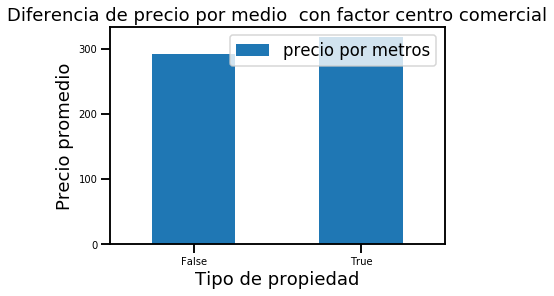

In [149]:
#comparando el factor de centro con el promedio de precio
df_cc_precio = df_centrocomercial.groupby('centroscomercialescercanos').agg({'precio por metros' :'mean'})
g = df_cc_precio.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor centro comercial", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=0)

In [150]:
#filtrar el dato de diferentes tipos con el promedio de pr

## **Analisis segun antiguedad**

In [151]:
df_filtrado['tipo'].value_counts()

Casa                  141717
Apartamento            57341
Casa en condominio     19297
Otros                  11654
Terreno                 9945
Name: tipo, dtype: int64

In [152]:
#Me quedo con aquellas publicaciones que tengan valores consistentes.

df_filtrado_antiguedad = df_filtrado.loc[df_filtrado['metrostotales'] > 0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['metroscubiertos'] > 0]

#Me quedo con tipos: Casa, Apartamento y Casa en condominio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[(df_filtrado_antiguedad['tipo'] != 'Otros') | (df_filtrado_antiguedad['tipo'] != 'Terreno')]

In [153]:
#Filtro las publicaciones que no tienen antiguedad ni precio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['antiguedad']>=0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['precio']>0]

#Calculo precio por m2

df_filtrado_antiguedad['precioporm2'] = df_filtrado_antiguedad['precio'] / df_filtrado_antiguedad['metrostotales']

In [154]:
#Calculo el promedio de precioporm2 segun la antiguedad por tipo (Casa, Apartamento, Casa en condominio)

df_filtered_casa = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa']
preciom2_segun_antiguedad_casa = df_filtered_casa.groupby('antiguedad').agg({'precioporm2' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa.reset_index(inplace = True)
preciom2_segun_antiguedad_casa.columns = ['antiguedad', 'precioporm2', 'cantidaddepublicaciones']

df_filtered_apartamento = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Apartamento']
preciom2_segun_antiguedad_apartamento = df_filtered_apartamento.groupby('antiguedad').agg({'precioporm2' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_apartamento.reset_index(inplace = True)
preciom2_segun_antiguedad_apartamento.columns = ['antiguedad', 'precioporm2', 'cantidaddepublicaciones']

df_filtered_casa_condo = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa en condominio']
preciom2_segun_antiguedad_casa_condo = df_filtered_casa_condo.groupby('antiguedad').agg({'precioporm2' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa_condo.reset_index(inplace = True)
preciom2_segun_antiguedad_casa_condo.columns = ['antiguedad', 'precioporm2', 'cantidaddepublicaciones']

In [155]:
#Filtro aquellos anios de antiguedad que tengan muy pocas publciaciones, asi se toman valores muestrales representativos.

cantidad_promedio_casa = preciom2_segun_antiguedad_casa['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa = preciom2_segun_antiguedad_casa.loc[preciom2_segun_antiguedad_casa['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_casa]

cantidad_promedio_apartamento = preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_apartamento = preciom2_segun_antiguedad_apartamento\
                            .loc[preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_apartamento]

cantidad_promedio_casa_condo = preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa_condo = preciom2_segun_antiguedad_casa_condo\
                            .loc[preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'] >= 0.1*cantidad_promedio_casa_condo]

Text(0.5, 1.0, 'Precio del m2 vs Antiguedad en Casas')

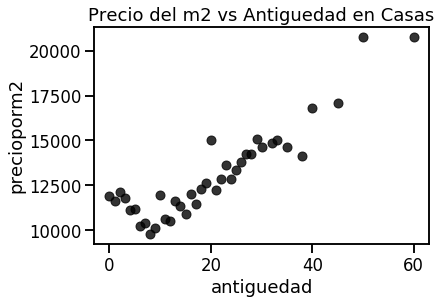

In [156]:
#Precio del metro cuadrado en Casas / Apartamentos / Casas en Condominio vs Antiguedad
sns.regplot(x=preciom2_segun_antiguedad_casa["antiguedad"], y=preciom2_segun_antiguedad_casa["precioporm2"], fit_reg = False, color = 'black')\
                            .set_title("Precio del m2 vs Antiguedad en Casas")

Text(0.5, 1.0, 'Precio del m2 vs Antiguedad en Apartamentos')

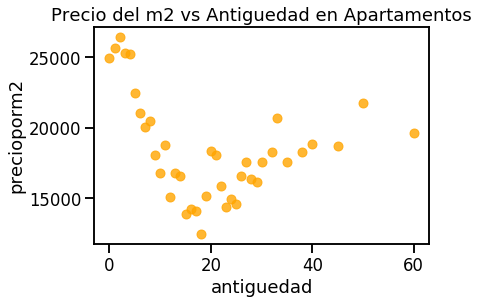

In [157]:
sns.regplot(x=preciom2_segun_antiguedad_apartamento["antiguedad"], y=preciom2_segun_antiguedad_apartamento["precioporm2"], fit_reg = False, color = 'orange')\
                            .set_title("Precio del m2 vs Antiguedad en Apartamentos")

Text(0.5, 1.0, 'Precio del m2 vs Antiguedad en Casa en condominio')

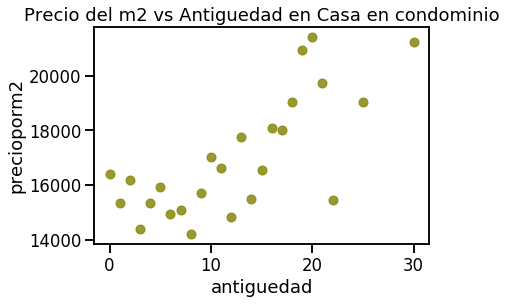

In [158]:
sns.regplot(x=preciom2_segun_antiguedad_casa_condo["antiguedad"], y=preciom2_segun_antiguedad_casa_condo["precioporm2"], fit_reg = False, color = 'olive')\
                            .set_title("Precio del m2 vs Antiguedad en Casa en condominio")

## **Analisis segun cantidad de banios, habitaciones, garages**

In [159]:
#Analisis de cantidad de banios y habitaciones

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio
df_filtrado_cantidades = df_filtrado.loc[(df_filtrado['tipo'] != 'Otros') | (df_filtrado['tipo'] != 'Terreno')]

#Me quedo con aquellos que tengan al menos una habitacion
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_habitaciones'] > 0]

In [160]:
habitaciones_grouped = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'id' : 'count'})
habitaciones_grouped.columns = ['cantidad_propiedades']
habitaciones_grouped.reset_index(inplace = True)
habitaciones_grouped['cant_habitaciones'] = habitaciones_grouped['cant_habitaciones'].apply(lambda x: x if x < 6 else "6+")
habitaciones_grouped = habitaciones_grouped.groupby('cant_habitaciones').agg({'cantidad_propiedades':'sum'})
habitaciones_grouped


,cantidad_propiedades
cant_habitaciones,
1.0,5069
2.0,57808
3.0,121887
4.0,25068
5.0,4596
6+,3101


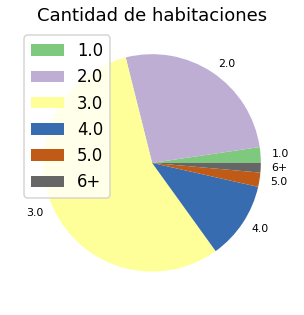

In [161]:
habitaciones_grouped.plot(kind='pie', figsize=(5,5),cmap='Accent',fontsize=11, y = 'cantidad_propiedades')
plt.title('Cantidad de habitaciones', fontsize = 18)
plt.ylabel('')
plt.show();

In [162]:
#Precio vs cantidad de habitaciones
precio_por_habitaciones = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'precio' : 'mean'})
precio_por_habitaciones.reset_index(inplace = True)
precio_por_habitaciones.columns = ['cantidad_de_habitaciones', 'precio_promedio']

Text(0.5, 1.0, 'Precio promedio vs cantidad de habitaciones')

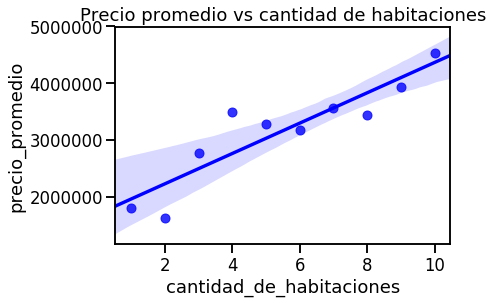

In [163]:
sns.regplot(x=precio_por_habitaciones["cantidad_de_habitaciones"], y=precio_por_habitaciones["precio_promedio"], color = 'blue')\
                .set_title("Precio promedio vs cantidad de habitaciones")

In [164]:
#Precio promedio vs cantidad de banos

#Filtro aquellos que no tengan banos
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_banios'] > 0]

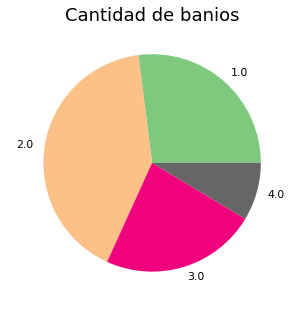

In [165]:
banios_grouped = df_filtrado_cantidades.groupby('cant_banios').size().plot(kind='pie', figsize=(5,5),cmap='Accent',fontsize=11)
plt.title('Cantidad de banios', fontsize = 18)
plt.ylabel('')
plt.show();

Text(0.5, 1.0, 'Precio promedio vs cantidad de banos')

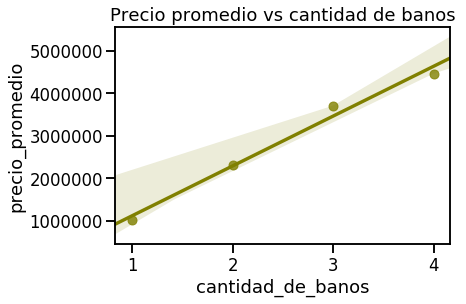

In [166]:
#Agrupo por cantidad de banos y calculo precio promedio
precio_por_banos = df_filtrado_cantidades.groupby('cant_banios').agg({'precio' : 'mean'})
precio_por_banos.reset_index(inplace = True)
precio_por_banos.columns = ['cantidad_de_banos', 'precio_promedio']

sns.regplot(x=precio_por_banos["cantidad_de_banos"], y=precio_por_banos["precio_promedio"], color = 'olive')\
                .set_title("Precio promedio vs cantidad de banos")

In [167]:
#Precio promedio vs cantidad de garages

#Filtro aquellos que no tengan garages
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_garages'] > 0]

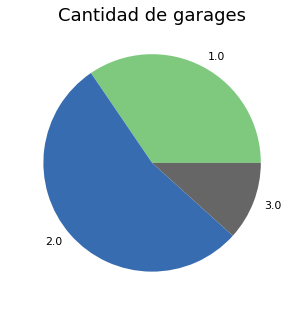

In [168]:
banios_grouped = df_filtrado_cantidades.groupby('cant_garages').size().plot(kind='pie', figsize=(5,5),cmap='Accent',fontsize=11)
plt.title('Cantidad de garages', fontsize = 18)
plt.ylabel('')
plt.show();

Text(0.5, 1.0, 'Precio promedio vs cantidad de garages')

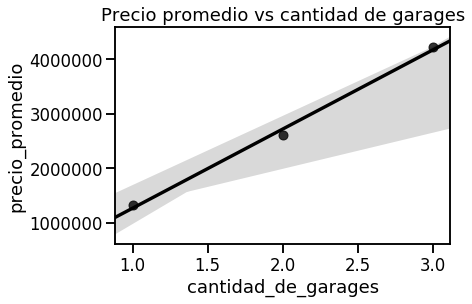

In [169]:
#Agrupo por cantidad de garages y calculo precio promedio
precio_por_garages = df_filtrado_cantidades.groupby('cant_garages').agg({'precio' : 'mean'})
precio_por_garages.reset_index(inplace = True)
precio_por_garages.columns = ['cantidad_de_garages', 'precio_promedio']

sns.regplot(x=precio_por_garages["cantidad_de_garages"], y=precio_por_garages["precio_promedio"], color = 'black')\
                .set_title("Precio promedio vs cantidad de garages")

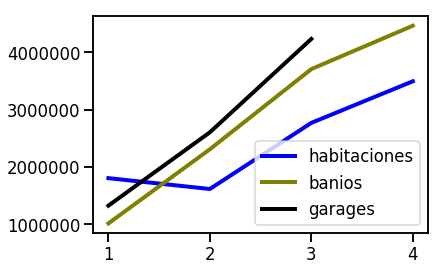

In [170]:
#Analizo en conjunto el precio vs cantidad_de_habitaciones, cantidad_de_banios, cantidad_de_garages

#Quito las publicaciones con mas de cuatro habitaciones asi ajusta la interseccion de las 3 categorias. La tendencia, de todas formas, ya se analizo por separado

precio_por_habitaciones = precio_por_habitaciones.drop([x for x in range(4, 10)])

plt.plot( 'cantidad_de_habitaciones', 'precio_promedio', data=precio_por_habitaciones, marker='', markerfacecolor='blue', color='blue', linewidth=4, label = "habitaciones")
plt.plot( 'cantidad_de_banos', 'precio_promedio', data=precio_por_banos, marker='', color='olive', linewidth=4, label = "banios")
plt.plot( 'cantidad_de_garages', 'precio_promedio', data=precio_por_garages, marker='', color='black', linewidth=4, label="garages")
plt.legend()

## **Análisis de las descripciones**

In [171]:
#Filtro aquellas publicaciones que no tengan descripciones
df_filtrado_descripciones = df_filtrado.loc[~df_filtrado.descripcion.isnull()]

In [172]:
def filtrar_descripciones(descripcion):
    descripcion = descripcion.replace("\n", "")
    descripcion = descripcion.replace("<p>", "")
    descripcion = descripcion.replace("<\p>", "")
    descripcion = descripcion.replace("nbsp", "")
    descripcion = descripcion.replace("ntilde", "")
    descripcion = descripcion.replace("ntil", "")
    descripcion = descripcion.replace("strong","")
    palabras = descripcion.split()
    for palabra in palabras:
        if len(palabra) <= 3:
            palabras.remove(palabra)
    descripcion_final = " ".join(palabras)
    return descripcion_final

df_filtrado_descripciones['descripcion'] = df_filtrado_descripciones['descripcion'].apply(filtrar_descripciones)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [173]:
descripciones = " ".join(descripcion for descripcion in df_filtrado_descripciones.descripcion)
print ("Hay {} palabras en total que conforman todas las descripciones".format(len(descripciones)))

Hay 83595332 palabras en total que conforman todas las descripciones


In [174]:
#Ajusto el WordCloud a la forma de una casa
mascara_casa = np.array(Image.open("files/casa.png"))
mascara_casa

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [175]:
def transformar_formato(valor):
    if valor == 0:
        return 255
    else:
        return valor

mascara_casa_transformada = np.ndarray((mascara_casa.shape[0],mascara_casa.shape[1]), np.int32)
for i in range(len(mascara_casa)):
    mascara_casa_transformada[i] = list(map(transformar_formato, mascara_casa[i]))
    
mascara_casa_transformada

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

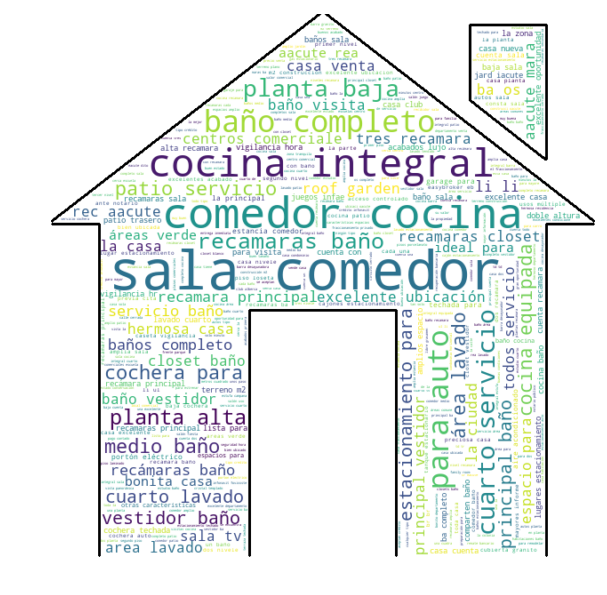

In [176]:
# Creo la imagen del WordCloud
wc = WordCloud(background_color="white", max_words=1000, mask=mascara_casa_transformada, contour_width=3, contour_color='black')

# Genero a partir de las palabras de las descripciones
wc.generate(descripciones)

# Lo guardo en un archivo
wc.to_file("files/wordcloud_casa.png")

# Mostrar
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Análisis por provincia**

### **Cantidad de publicaciones por provincia**

In [177]:
state_geo = 'files/mexican_states.json'

In [178]:
#Veo cuantas publicaciones hay por estado

#Primero, filtro aquellos que no tengan info del estado:
df_filtrado_provincias = df_filtrado.loc[~df_filtrado['provincia'].isnull()]

In [179]:
#Reemplazo los nombres por los del GeoJSON
df_filtrado_provincias['provincia'] = df_filtrado_provincias['provincia'].replace({'Edo. de México' : 'Mexico',
                                               'Querétaro' : 'Queretaro',
                                               'Nuevo León' : 'Nuevo Leon',
                                               'San luis Potosí' : 'San Luis Potosi',
                                               'Yucatán' : 'Yucatan',
                                               'Baja California Norte' : 'Baja California',
                                               'Michoacán' : 'Michoacan'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [180]:
#Sumo la cantidad de publicaciones por provincia
cantidad_por_provincia = df_filtrado_provincias.groupby('provincia').agg({'id' : 'count'})
cantidad_por_provincia.reset_index(inplace = True)
cantidad_por_provincia.columns = ['provincia', 'cantidad_de_publicaciones']

In [181]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [182]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=cantidad_por_provincia,
    columns=['provincia', 'cantidad_de_publicaciones'],
    key_on='properties.admin_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cantidad de publicaciones por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

## **Provincias más caras** (precio por m2 promedio por provincia)

In [183]:
#Analizo el precio por m2 promedio por provincia

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio

df_filtrado_provincias = df_filtrado_provincias.loc[(df_filtrado['tipo'] != 'Otros') | (df_filtrado['tipo'] != 'Terreno')]

#Me quedo con aquellas cuyo precio sea mayor a cero

df_filtrado_provincias = df_filtrado_provincias.loc[df_filtrado_provincias['precioporm2'] > 0]

In [184]:
#Calculo el precio promedio por provincia
precio_promedio_provincia = df_filtrado_provincias.groupby('provincia').agg({'precioporm2' : 'mean'})
precio_promedio_provincia.reset_index(inplace = True)
precio_promedio_provincia.columns = ['provincia', 'precio_por_m2_mean']

In [185]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [186]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=precio_promedio_provincia,
    columns=['provincia', 'precio_por_m2_mean'],
    key_on='properties.admin_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cantidad de publicaciones por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

In [187]:
precio_promedio_provincia = precio_promedio_provincia.sort_values(by = 'precio_por_m2_mean', ascending = False)
precio_promedio_provincia

,provincia,precio_por_m2_mean
8,Distrito Federal,24026.248209
11,Guerrero,15307.854270
14,Mexico,14694.225491
18,Nuevo Leon,14688.246125
13,Jalisco,13950.298446
26,Tabasco,13486.156411
22,Quintana Roo,13447.910359
20,Puebla,13293.161747
4,Chiapas,12012.360462
16,Morelos,11354.575077


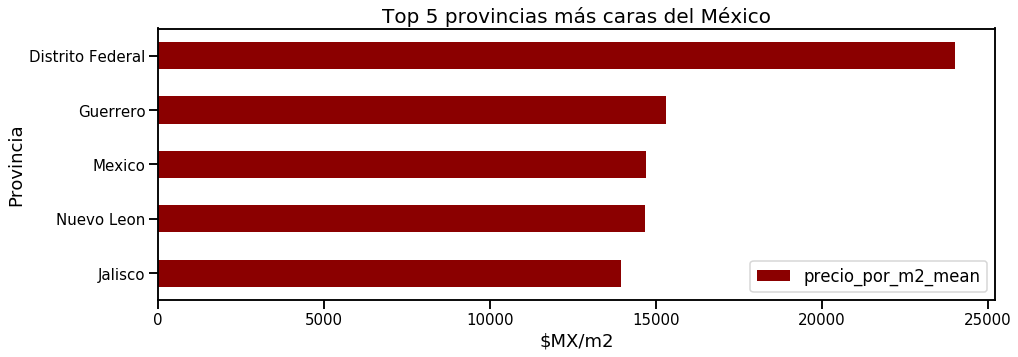

In [188]:
#Las cinco provincias cuyo precio promedio por m2 es mas alto

graph = precio_promedio_provincia.head(5).sort_values(by = 'precio_por_m2_mean').plot.barh(figsize=(15,5),color='darkred',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más caras del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()

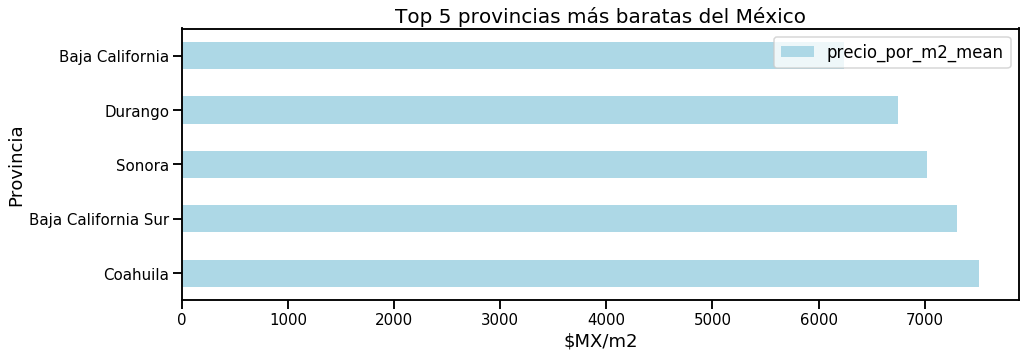

In [189]:
#Las cinco provincias cuyo precio por m2 es mas bajo

graph = precio_promedio_provincia.tail(5).sort_values(by = 'precio_por_m2_mean', ascending = False).plot.barh(figsize=(15,5),color='lightblue',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más baratas del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()

# Posibles 'extras'

In [190]:
# Veremos primero la cantidad total de propiedades que tienen cada extra en un diagrama de conjuntos (Venn)

posibles_extras = ['piscina', 'gimnasio', 'usosmultiples']

def contar_extras(df):
    valor = {}
    valor['valor'] = max([df[extra].sum() for extra in posibles_extras])
    return pd.Series(valor)

# Generamos un dataframe con un índice múltiple indicando si está el dado extra o no

cantidad_extras = df_original.groupby(posibles_extras)[posibles_extras].apply(contar_extras)
cantidad_extras.loc[False, False, False] = df_original.shape[0]-cantidad_extras['valor'].sum()
cantidad_extras

valor
piscina gimnasio usosmultiples        
False   False    False          206412
                 True             4988
        True     False            5618
                 True             2010
True    False    False           11709
                 True             1897
        True     False            3039
                 True             4327

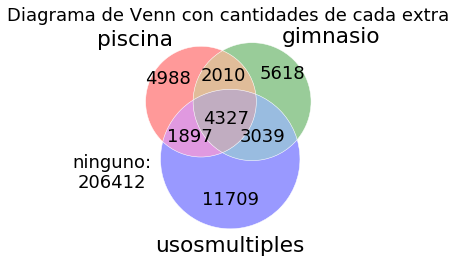

In [191]:
# Diagrama de venn de la cantidad de cada extra

plt.title("Diagrama de Venn con cantidades de cada extra")

venn3(subsets = cantidad_extras['valor'][1:], set_labels=cantidad_extras.index.names, ax=plt.gca())
venn3_circles(subsets = cantidad_extras['valor'][1:], linewidth=0.5, color="white")

plt.annotate(f'ninguno:\n{cantidad_extras.loc[False, False, False].valor}',xy = np.array([-0.3, 0.05]), xytext=(-70,-70),\
ha='center', textcoords='offset points')

plt.show()


In [192]:
# Veremos qué porcentaje de cada tipo tiene cada extra

tipo_por_extra = df_filtrado_tipo.groupby('tipo').agg({extra:'sum' for extra in posibles_extras})
tipo_por_extra

,piscina,gimnasio,usosmultiples
tipo,,,
Apartamento,8095.0,7591.0,6187.0
Casa,9109.0,6105.0,5099.0
Casa en condominio,2973.0,1262.0,1907.0
Otros,305.0,35.0,29.0
Terreno,489.0,1.0,0.0


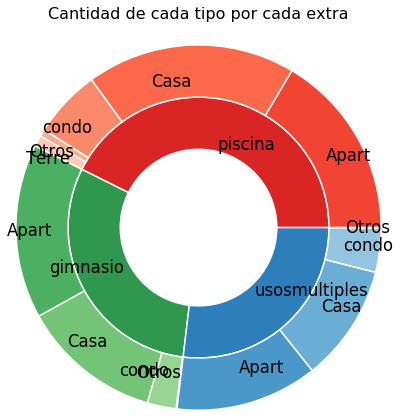

In [193]:
# Consideramos que el valor de 'gimnasio' para el terreno es despreciable, así que lo seteamos a 0

tipo_por_extra['gimnasio'].loc['Terreno'] = 0

# Generamos un diagrama en forma de 'dona' para las cantidades de cada tipo por cada extra

fig, ax = plt.subplots()

colores = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]

# Anillo interior (extras)
anillo1, _ = ax.pie([tipo_por_extra[extra].sum() for extra in posibles_extras], radius=1.5,\
                  labels=posibles_extras, labeldistance=0.65, colors=[color(0.7) for color in colores])
plt.setp(anillo1, width=0.6, edgecolor='white')
 
# Anillo exterior (tipo por cada extra)
subgrupos = [tipo.split(' ')[-1][:5] for i in range(3) for tipo in tipo_por_extra.index]
subgrupos.pop(9) # Eliminamos 'Terreno' para gimnasio y usosmultiples
subgrupos.pop(13)

anillo2, _ = ax.pie([x for columna in tipo_por_extra.columns for x in tipo_por_extra[columna] if x != 0], radius=2.1,\
                    labels=subgrupos, labeldistance=0.8,\
                    colors=[colores[0](i/10) for i in range(6, 1, -1)] + [color(i/10) for color in colores[1:] for i in range(6,2,-1)])
plt.setp(anillo2, width=0.6, edgecolor='white')

fig.patch.set_facecolor('white')
plt.title('Cantidad de cada tipo por cada extra',pad=100, fontsize=16)
plt.margins(0,0) 
plt.show()



# Analizar el precio y relacion con metros

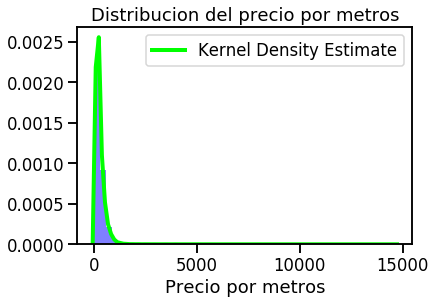

In [194]:
#analiazando distribucion generar de precio por metros
figure = plt.figure()

plt.title('Distribucion del precio por metros', color = 'black')

sns.set_context('talk')
sns.set_context('talk')
sns.distplot(df_filtrado['precio por metros'],axlabel = "Precio por metros",\
            kde_kws={"color": "lime", "lw":4, "label": "Kernel Density Estimate"},\
            hist_kws={"linewidth": 10, "alpha": 0.5, "color": "b"})

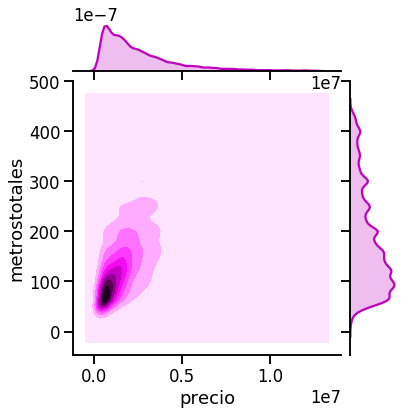

In [195]:
#distribucion de precio y metros totales
sns.jointplot(x=df_filtrado["precio"], y=df_filtrado["metrostotales"], kind = 'kde', s=200, color='m', edgecolor="skyblue", linewidth=2)

# Analizar precio por metros con ciudades

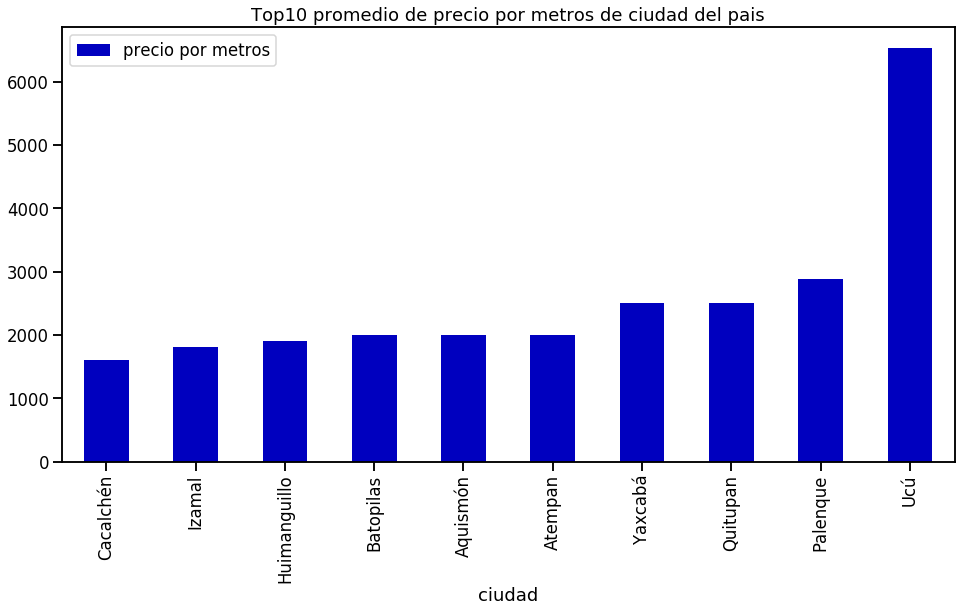

In [196]:
#analizando top 10 ciudades del pais con mayor precio por metros
df_ciudad = df_filtrado.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_top10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_top10
df_ciudad_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Top10 promedio de precio por metros de ciudad del pais' )

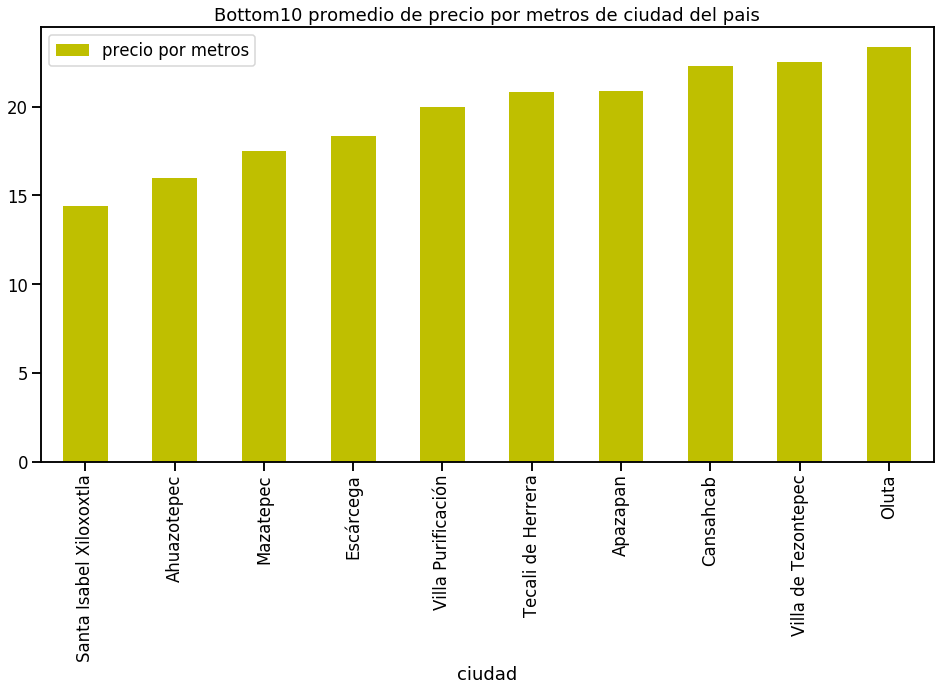

In [197]:
#analizando bottom 10 ciudades del pais con menor precio por metros
df_ciudad_bottom10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_bottom10
df_ciudad_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0),title = 'Bottom10 promedio de precio por metros de ciudad del pais' )

In [46]:
data=pd.read_csv('ciudad_20.csv',sep = ',')
m = folium.Map(location=[20, -95], tiles="OpenStreetMap", zoom_start=6)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)
 
# Save it as html
m.save('mymap_pais.html')
m

In [19]:
#analizo top 5 provincias con mayor publicacion de ventas
df_filtrado['provincia'].value_counts(normalize = 1)

Distrito Federal         0.245117
Edo. de México           0.173475
Jalisco                  0.088549
Querétaro                0.070829
Nuevo León               0.063891
Puebla                   0.043449
San luis Potosí          0.035219
Yucatán                  0.033055
Morelos                  0.030591
Veracruz                 0.024024
Quintana Roo             0.019829
Chihuahua                0.019137
Coahuila                 0.015406
Baja California Norte    0.013425
Sonora                   0.012458
Guanajuato               0.011924
Guerrero                 0.011166
Hidalgo                  0.010511
Michoacán                0.010302
Tamaulipas               0.009602
Durango                  0.009485
Sinaloa                  0.007530
Aguascalientes           0.007309
Baja California Sur      0.007088
Nayarit                  0.005637
Chiapas                  0.004695
Colima                   0.004203
Tabasco                  0.004144
Tlaxcala                 0.003498
Oaxaca        

## con ciudades de Distrito Federal

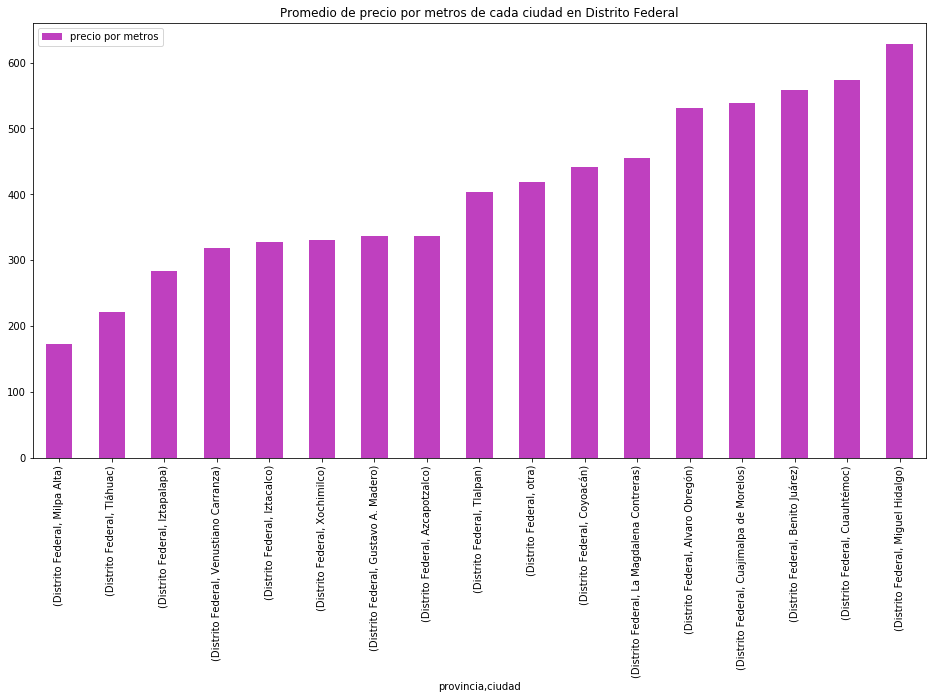

In [41]:
#ya que hay menos de 20 ciudades en distrito federal, se presenta en un grafico
df_distritofederal = df_filtrado[df_filtrado.provincia == 'Distrito Federal']
df_ciudad_df = df_distritofederal[['provincia','ciudad','precio por metros']]
df_ciudad_df = df_ciudad_df.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_df.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.75),title = 'Promedio de precio por metros de cada ciudad en Distrito Federal')

In [49]:
data=pd.read_csv('ciudad_df.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=11)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*5,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)
 
# Save it as html
m.save('mymap_df.html')
m

## con ciudades de edo. mexico

,precio por metros
ciudad,
Villa Victoria,1393.673077
Temamatla,1014.790679
Ocuilan,833.333333
Temascalapa,706.090482
Villa Guerrero,625.796803
PolotitlAn,590.440279
Huixquilucan,463.490428
Tepetlaoxtoc,437.199361
Texcaltitlán,418.181818


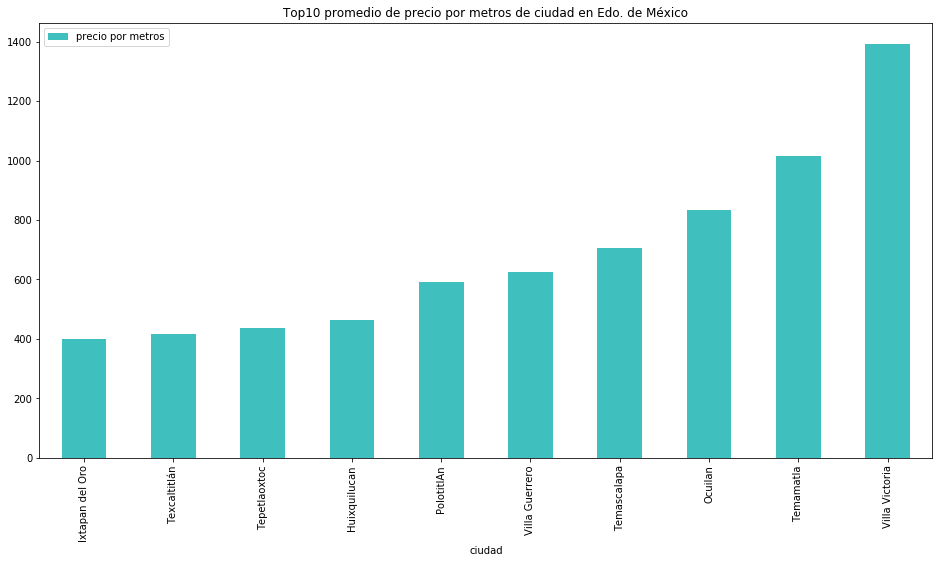

In [28]:
df_edomexico = df_filtrado[df_filtrado.provincia == 'Edo. de México']
df_ciudad_em = df_edomexico[['ciudad','precio por metros']]
df_ciudad_em = df_ciudad_em.groupby('ciudad').agg({'precio por metros':'mean'})

df_ciudad_em_top10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_em_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.25, 0.75, 0.75),title = 'Top10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_top10

,precio por metros
ciudad,
Donato Guerra,25.600000
Santo Tomás,29.000000
Almoloya del Río,50.909091
Tequixquiac,75.285714
Tianguistenco,76.141885
Ayapango,85.000000
Axapusco,86.250000
San José del Rincón,95.000000
Ecatzingo,103.333333


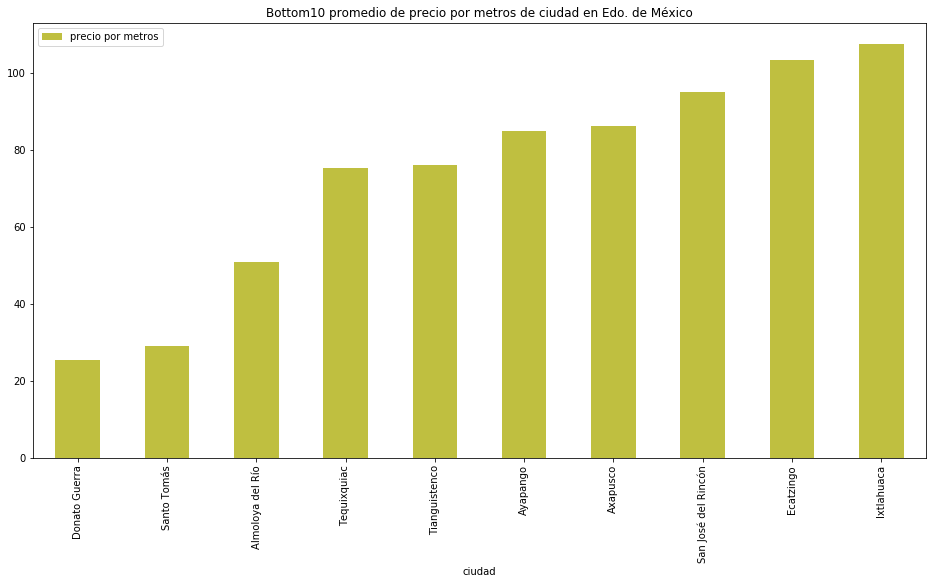

In [29]:
df_ciudad_em_bottom10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_em_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0.25),title = 'Bottom10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_bottom10

In [30]:
data=pd.read_csv('ciudad_em.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*20,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(m)
 
# Save it as html
m.save('mymap_em.html')
m

## con ciudades de Jalisco

In [31]:
df_jalisco = df_filtrado[df_filtrado.provincia == 'Jalisco']
df_ciudad_ja = df_jalisco[['ciudad','precio por metros']]
df_ciudad_ja = df_ciudad_ja.groupby('ciudad').agg({'precio por metros':'mean'})

,precio por metros
ciudad,
Quitupan,2500.000000
ácatlán de Juárez,898.852321
Yahualica de González Gallo,833.333333
Atengo,803.274419
Villa Corona,732.987449
Ahualulco de Mercado,507.521008
Zapotlanejo,499.075654
Zacoalco de Torres,444.180847
Tequila,415.616818


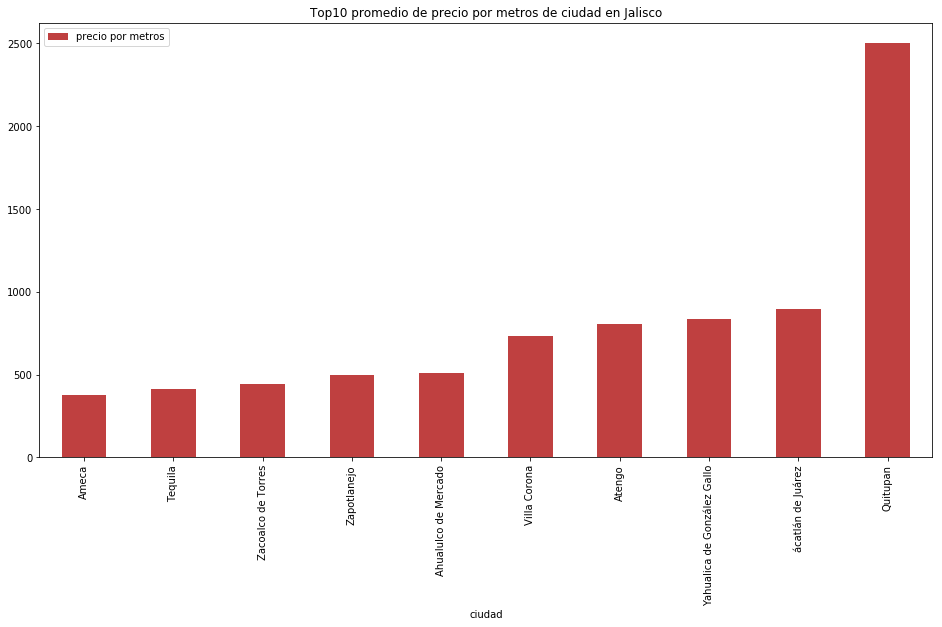

In [32]:
df_ciudad_ja_top10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_ja_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_top10

,precio por metros
ciudad,
Villa Purificación,20.000000
Cuautitlán de García Barragán,63.333333
Colotlán,68.576966
Cocula,89.295775
Concepción de Buenos Aires,89.552239
Zapotiltic,95.378017
Tototlán,96.364221
San Gabriel,115.384615
áutlán de Navarro,117.549020


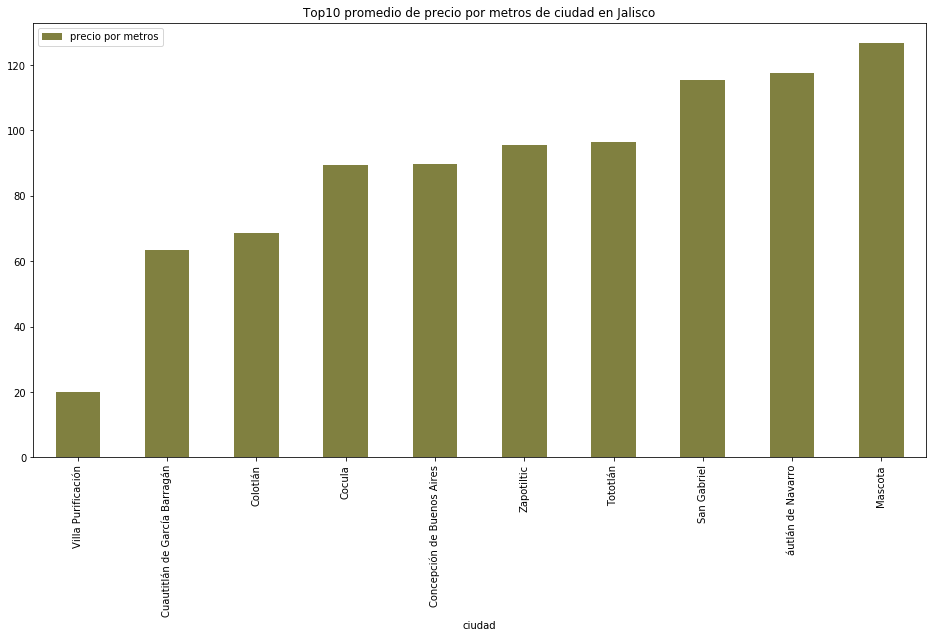

In [33]:
df_ciudad_ja_bottom10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_ja_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.5, 0.5, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_bottom10

In [34]:
data=pd.read_csv('ciudad_ja.csv',sep = ',')
m = folium.Map(location=[20, -103.2], tiles="OpenStreetMap", zoom_start=8)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='Purple',
      fill=True,
      fill_color='Purple'
   ).add_to(m)
 
# Save it as html
m.save('mymap_ja.html')
m

## con ciudades de Querétaro

precio por metros
provincia ciudad                                
Querétaro Amealco de Bonfil           136.010915
          Arroyo Seco                 190.513831
          Colón                       382.671854
          Corregidora                 197.112230
          El Marqués                  236.515108
          Ezequiel Montes             152.497961
          Huimilpan                   209.724728
          Pedro Escobedo              228.411656
          Querétaro                   228.717883
          San Juan del Río            187.045518
          Tequisquiapan               173.584436
          Tolimán                     836.111111
          Cadereyta de Montes         203.024877
          San Joaquín                 108.504399
          Jalpan de Serra              50.133333
          Pinal de Amoles             130.000000

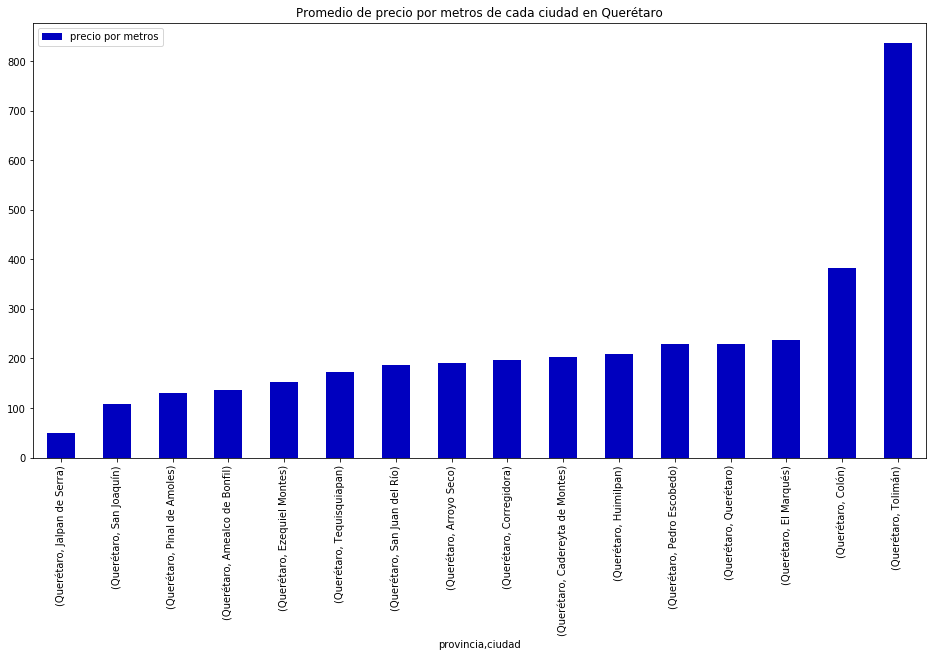

In [39]:
#son menor que 20 ciudades
df_queretaro  = df_filtrado[df_filtrado.provincia == 'Querétaro']
df_ciudad_qe = df_queretaro [['provincia','ciudad','precio por metros']]
df_ciudad_qe = df_ciudad_qe.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_qe.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Promedio de precio por metros de cada ciudad en Querétaro')
df_ciudad_qe

In [47]:
data=pd.read_csv('ciudad_qe.csv',sep = ',')
m = folium.Map(location=[20.87, -100], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('mymap_qe.html')
m

## con ciudades de Nuevo León

In [42]:
df_nl = df_filtrado[df_filtrado.provincia == 'Nuevo León']
df_ciudad_nl = df_nl [['ciudad','precio por metros']]
df_ciudad_nl = df_ciudad_nl.groupby('ciudad').agg({'precio por metros':'mean'})

,precio por metros
ciudad,
Mina,1323.076923
Villaldama,1100.000000
Gral. Treviño,800.000000
San Pedro Garza García,665.943734
Los Herreras,644.827586
Salinas Victoria,633.731646
Allende,523.514379
Montemorelos,412.206893
AnAhuac,404.769536


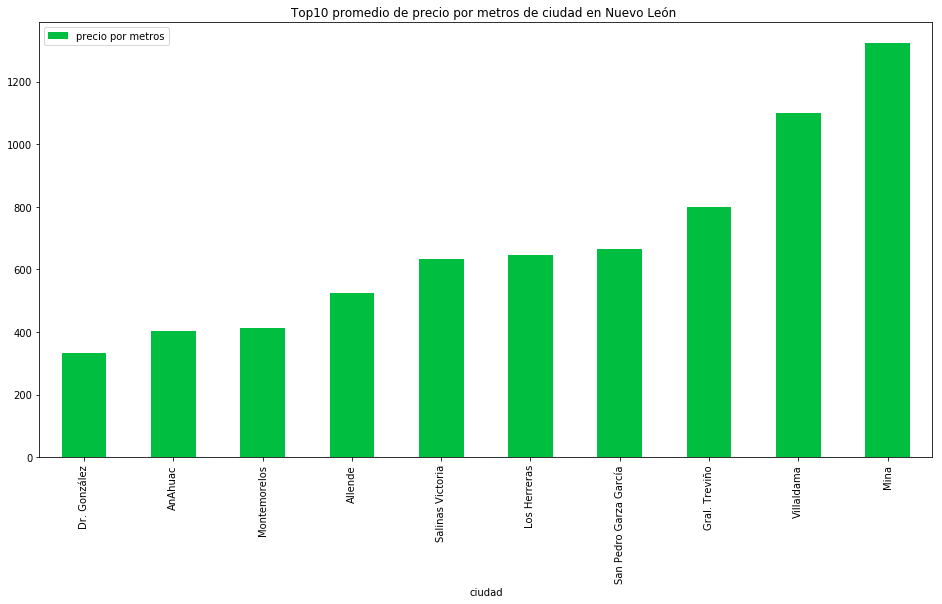

In [43]:
df_ciudad_nl_top10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_nl_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0.75, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Nuevo León ')
df_ciudad_nl_top10

,precio por metros
ciudad,
Hidalgo,36.875000
Los Ramones,42.756554
Cerralvo,58.000000
Higueras,73.697556
Dr. Arroyo,83.601286
Gral. Bravo,111.111111
Juárez,128.655724
Rayones,140.000000
Apodaca,145.488995


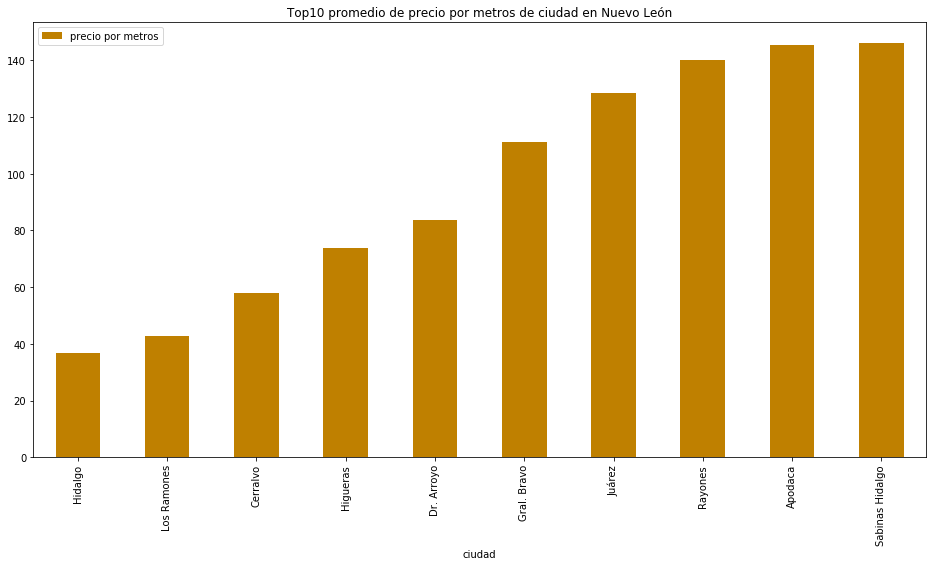

In [44]:
df_ciudad_nl_bottom10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_nl_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.5, 0),title = 'Top10 promedio de precio por metros de ciudad en Nuevo León')
df_ciudad_nl_bottom10

In [45]:
data=pd.read_csv('ciudad_nl.csv',sep = ',')
m = folium.Map(location=[26, -100], tiles="OpenStreetMap", zoom_start=7)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*40,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('mymap_nl.html')
m

# Tipos a lo largo de los años

In [199]:
tipos_antiguedad = df_filtrado_tipo.copy()
tipos_antiguedad['aux'] = 1
tipos_antiguedad['antiguedad'] = 2016-tipos_antiguedad['antiguedad']

tipos_antiguedad = tipos_antiguedad.pivot_table(values='aux', index='antiguedad', columns='tipo', aggfunc='sum', dropna=True, fill_value=0)

# Agregamos todas las angigüedades faltantes con 0
for i in range(int(min(tipos_antiguedad.index)),int(max(tipos_antiguedad.index))):
    if i not in tipos_antiguedad.index:
        tipos_antiguedad.loc[i] = 0

tipos_antiguedad = tipos_antiguedad.sort_index().cumsum(axis=0)

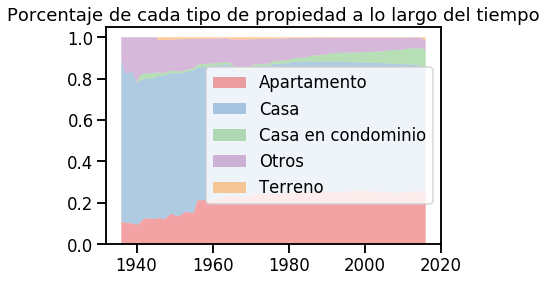

In [200]:
# Gráfico de % de cada tipo en realación al año

porcentaje_tipos_antiguedad = tipos_antiguedad.divide(tipos_antiguedad.sum(axis=1), axis=0)

plt.title('Porcentaje de cada tipo de propiedad a lo largo del tiempo')
plt.stackplot(porcentaje_tipos_antiguedad.index,*(porcentaje_tipos_antiguedad[columna] for columna in porcentaje_tipos_antiguedad.columns), labels=tipos_antiguedad.columns, colors=sns.color_palette("Set1"), alpha=0.4 )
plt.legend(loc='right')
plt.show()


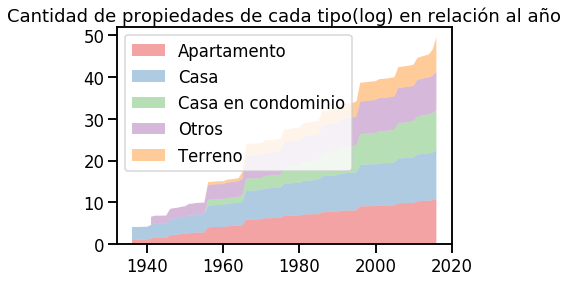

In [201]:
# Gráfico de crecimiento de cada tipo en relación al año

plt.title('Cantidad de propiedades de cada tipo(log) en relación al año')
plt.stackplot(tipos_antiguedad.index,*(np.log(tipos_antiguedad[columna]) for columna in tipos_antiguedad.columns), labels=tipos_antiguedad.columns, colors=sns.color_palette("Set1"), alpha=0.4 )
plt.legend(loc='upper left')
plt.show()

In [202]:
# Calculamos precio promedio por tipo a lo largo de los años
precio_antiguedad = df_filtrado_tipo.copy()
precio_antiguedad['antiguedad'] = 2016-precio_antiguedad['antiguedad']

precio_antiguedad = precio_antiguedad.groupby(['tipo', 'antiguedad'])['precio'].mean().reset_index()
precio_antiguedad

,tipo,antiguedad,precio
0,Apartamento,1936.0,9.033333e+05
1,Apartamento,1941.0,1.350000e+06
2,Apartamento,1942.0,1.250000e+06
3,Apartamento,1946.0,1.712500e+06
4,Apartamento,1948.0,1.250000e+06
...,...,...,...
275,Terreno,2012.0,1.264263e+06
276,Terreno,2013.0,1.075392e+06
277,Terreno,2014.0,1.483746e+06
278,Terreno,2015.0,1.930856e+06


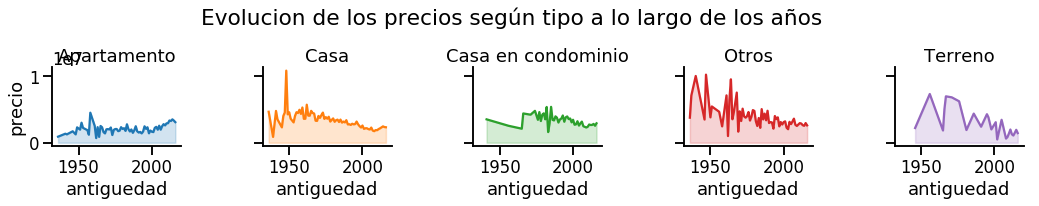

In [203]:
# 

g = sns.FacetGrid(precio_antiguedad, col='tipo', hue='tipo', col_wrap=5)
 
g = g.map(plt.plot, 'antiguedad', 'precio')
 
g = g.map(plt.fill_between, 'antiguedad', 'precio', alpha=0.2).set_titles("{col_name}")
 
g = g.set_titles("{col_name}")
 
plt.subplots_adjust(top=0.7)
g = g.fig.suptitle('Evolucion de los precios según tipo a lo largo de los años')
 
plt.show()
